# Initialize Packages

In [1]:
# Seaborn
import seaborn as sns

# SciPy
import scipy
import scipy.stats as stats

# h5py
import h5py as h5

# NumPy
import numpy as np

# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec as GS
from matplotlib import rc
from matplotlib import cm
%matplotlib inline

# Corner
from corner import corner

# Sys, OS, glob
import sys, os
from glob import glob
from collections import OrderedDict

# Aesthetics

In [2]:
# Predefined Colors
dodgerblue      = '#1E90FF'
crimson         = '#DC143C'
lawngreen       = '#7CFC00'
blueviolet      = '#8A2BE2'
walesaway       = '#293133'
waleshome       = '#ff0038'
schoenbrgold    = '#F0D077'
wienblue        = '#006699'
wiengrey        = '#666666'
emeraldgreen    = '#50C878'
austrianred     = '#D80010'
tanzaniablue    = '#00a3dd'
tanzaniagreen   = '#1eb53a'

In [3]:
# Associate Colours
adiabaticCol = dodgerblue
urCol        = waleshome
quadCol      = wiengrey
octCol       = tanzaniagreen

In [4]:
# Set colour palette
cp = [dodgerblue,waleshome,wiengrey,tanzaniagreen,blueviolet]

In [5]:
rc_params = {'backend': 'pdf',
             'axes.linewidth': 1.75,
             'axes.labelsize': 10,
             'axes.titlesize': 10,
             'font.size': 10,
             'legend.fontsize': 10,
             'xtick.labelsize': 12,
             'ytick.labelsize': 12,
             'font.family': 'sans-serif',
             'font.sans-serif': ['Bitstream Vera Sans'],
             'font.serif': ['Times New Roman'],
             'text.usetex':True
            }

plt.rcParams.update(rc_params)

In [6]:
def getParam(param):
    switcher = {
        'mc' : r'$\mathcal{M}_c$',
        'q'  : r'$q$',
        'm1_detector_frame_Msun' : r'$m_1^{\rm{det}} \left[ M_{\odot} \right]$',
        'm2_detector_frame_Msun' : r'$m_2^{\rm{det}} \left[ M_{\odot} \right]$',
        'mtotal':r'$\M_{\rm{tot}}$',
        'symmetric_mass_ratio': r'$\eta$',
        'omega_quad_1': r'$\Omega_{2,A}$',
        'omega_quad_2': r'$\Omega_{2,B}$',
        'omega_oct_1': r'$\Omega_{3,A}$',
        'omega_oct_2': r'$\Omega_{3,B}$',
        'lambda_quad_1': r'$\Lambda_{2,A}$',
        'lambda_quad_2': r'$\Lambda_{2,B}$',
        'lambda_oct_1': r'$\Lambda_{3,A}$',
        'lambda_oct_2': r'$\Lambda_{3,B}$',
        'lambda_tilde': r'$\tilde{\Lambda}$',
        'delta_lambda_tilde': r'$\delta \tilde{\Lambda}$',
    }
    return switcher.get(param, "Invalid label")
    

In [7]:
def escapeLatex(text):
    if text: import matplotlib
    if text and matplotlib.rcParams['text.usetex']:
        return text.replace('_', '{\\textunderscore}')
    else:
        return text

# Utility Functions

In [8]:
def mass1_and_mass2_to_symmetric_mass_ratio(mass_1, mass_2):
    """
    Convert the component masses of a binary to its symmetric mass ratio.

    Parameters
    ----------
    mass1: float
        Mass of larger companion (solar masses)
    mass2: float
        Mass of smaller companion (solar masses)

    Return
    ------
    symmetric_mass_ratio: float
        Symmetric mass ratio of the binary (often denoted \eta or \nu in the literature)
    """

    return (mass_1 * mass_2) / (mass_1 + mass_2) ** 2.0


In [9]:
def mass1_and_mass2_to_total_mass(chirp_mass, total_mass):
    """
    Convert component masses to the total mass

    Parameters
    ----------
    mass1: float
        Mass of larger companion (solar masses)
    mass2: float
        Mass of smaller companion (solar masses)

    Return
    ------
    total_mass: float
        Total mass of the binary (solar masses)
    """

    return mass1 + mass2

In [10]:
def lambda_1_lambda_2_to_lambda_tilde(lambda_1, lambda_2, mass_1, mass_2):
    """
    Convert the component tidal deformabilities to the effective tidal deformability

    See, e.g., Wade et al., https://arxiv.org/pdf/1402.5156.pdf.

    Parameters
    ----------
    lambda_1: float
        Tidal parameter of heavier neutron star
    lambda_2: float
        Tidal parameter of lighter neutron star
    mass_1: float
        Mass of heavier neutron star
    mass_2: float
        Mass of lighter neutron star

    Return
    ------
    lambda_tilde: float
        Effective tidal deformability
    """
    eta           = mass1_and_mass2_to_symmetric_mass_ratio(mass_1, mass_2)
    lambda_plus   = lambda_1 + lambda_2
    lambda_minus  = lambda_1 - lambda_2
    
    lambda_tilde  = (8.0 / 13.0) * ( (1.0 + 7.0 * eta - 31.0 * eta**2.0) * lambda_plus 
                            + (1.0 - 4.0 * eta)**0.5 * (1.0 + 9.0 * eta - 11.0 * eta**2.0) * lambda_minus)

    return lambda_tilde


In [11]:
def lambda_1_lambda_2_to_delta_lambda_tilde(lambda_1, lambda_2, mass_1, mass_2):
    """
    Convert the component tidal deformabilities to the asymmetric effective tidal deformability


    Parameters
    ----------
    lambda_1: float
        Tidal parameter of heavier neutron star
    lambda_2: float
        Tidal parameter of lighter neutron star
    mass_1: float
        Mass of heavier neutron star
    mass_2: float
        Mass of lighter neutron star

    Return
    ------
    delta_lambda_tilde: float
        Asymmetric effective tidal deformability
    """
    eta          = mass1_and_mass2_to_symmetric_mass_ratio(mass_1, mass_2)
    lambda_plus  = lambda_1 + lambda_2
    lambda_minus = lambda_1 - lambda_2
    
    delta_lambda_tilde = (1.0 / 2.0) * ( (1.0 - 4.0 * eta) ** 0.5 
                                * (1.0 - (13272.0 / 1319.0) * eta + (8944.0 / 1319.0) * eta**2.0) * lambda_plus 
                            + (1.0 - (15910.0 / 1319.0) * eta + (32850.0 / 1319.0) * eta**2.0 
                               + (3380.0 / 1319.0) * eta**3.0) * lambda_minus)

    return delta_lambda_tilde


In [27]:
def f_mode_frequency_in_Hz(mass, Omega):
    """
    Converts the dimensionless angular f-mode frequency (\Omega) to the frequency in Hz


    Parameters
    ----------
    mass: float
        Mass of the neutron star
    omega: float
        Dimensionless angular f-mode frequency

    Return
    ------
    f: float
        f-mode frequency in Hz
    """
    # Solar mass in seconds
    Msec = 4.925491025543576e-06
    
    return Omega/(2.0 * mass * np.pi * Msec)

# Load Data

In [12]:
dataDir = './PosteriorSamples/';

In [13]:
# Set Data Paths

In [14]:
dataPaths = {
    'Adiabatic_Combined':           dataDir+'Adiabatic_Combined_posterior_samples.dat',
    'Universal_Relations_Combined': dataDir+'Universal_Relations_Combined_posterior_samples.dat',
    'Quadrupolar_Combined':         dataDir+'Quadrupolar_Combined_posterior_samples.dat',
    'Octupolar_Combined':           dataDir+'Octupolar_Combined_posterior_samples.dat'
}

In [15]:
for name, infile in dataPaths.items():
    print(name)
    print(infile)

Adiabatic_Combined
./PosteriorSamples/Adiabatic_Combined_posterior_samples.dat
Universal_Relations_Combined
./PosteriorSamples/Universal_Relations_Combined_posterior_samples.dat
Quadrupolar_Combined
./PosteriorSamples/Quadrupolar_Combined_posterior_samples.dat
Octupolar_Combined
./PosteriorSamples/Octupolar_Combined_posterior_samples.dat


In [17]:
# Load Posteriors Samples

name         = 'Adiabatic_Combined';
infile       = dataDir+'Adiabatic_Combined_posterior_samples.dat'
AdiabaticPos = dict([(name, np.genfromtxt(infile, names=True))])

name         = 'Universal_Relations_Combined';
infile       = dataDir+'Universal_Relations_Combined_posterior_samples.dat'
URPos        = dict([(name, np.genfromtxt(infile, names=True))])

name         = 'Quadrupolar_Combined';
infile       = dataDir+'Quadrupolar_Combined_posterior_samples.dat'
QuadPos      = dict([(name, np.genfromtxt(infile, names=True))])

name         = 'Octupolar_Combined';
infile       = dataDir+'Octupolar_Combined_posterior_samples.dat'
OctPos       = dict([(name, np.genfromtxt(infile, names=True))])

# Plot Posteriors

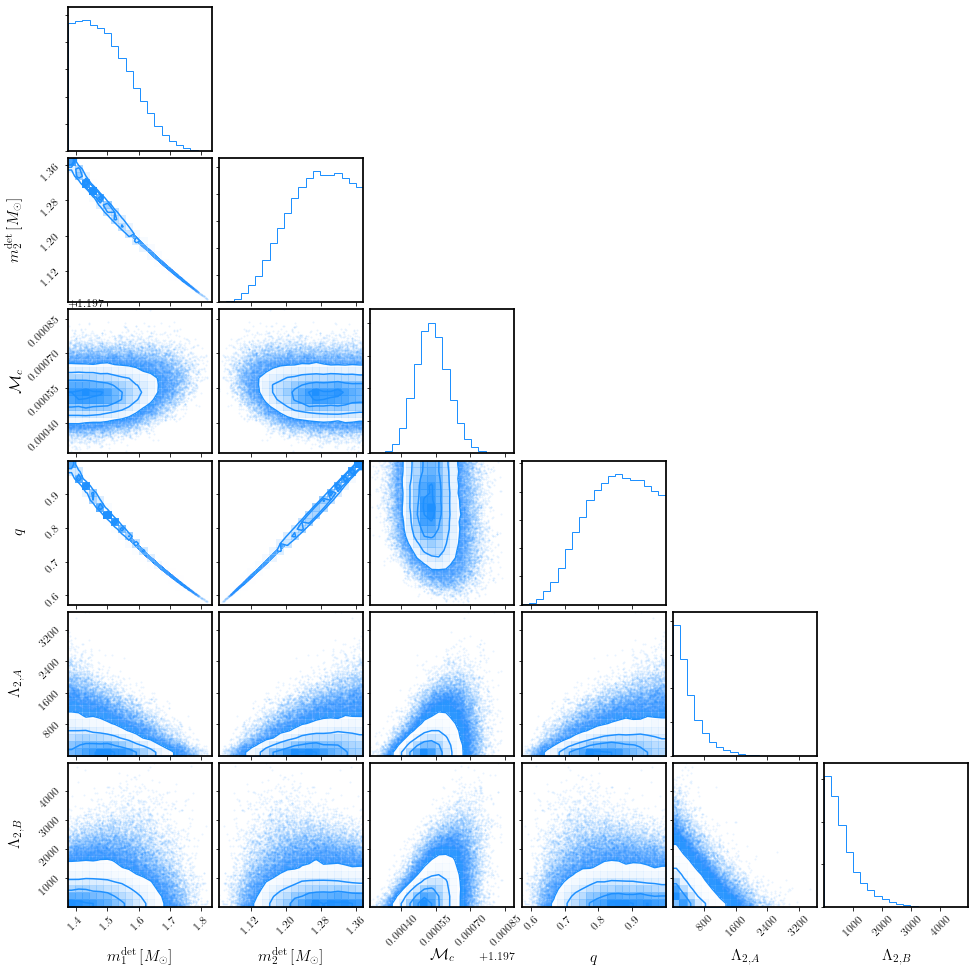

In [18]:
fig = None

# Get parameter names
adParams = [];
for i in range(0,len(AdiabaticPos['Adiabatic_Combined'].dtype.names)):
    adParams = np.append(adParams,getParam(AdiabaticPos['Adiabatic_Combined'].dtype.names[i]))

for i, pos in enumerate(AdiabaticPos.values()):
    fig = corner(pos.view(float).reshape(-1, len(pos.dtype)),
                 labels=adParams,
                 label_kwargs=dict(fontsize=16),
                 color=cp[0], fig=fig)

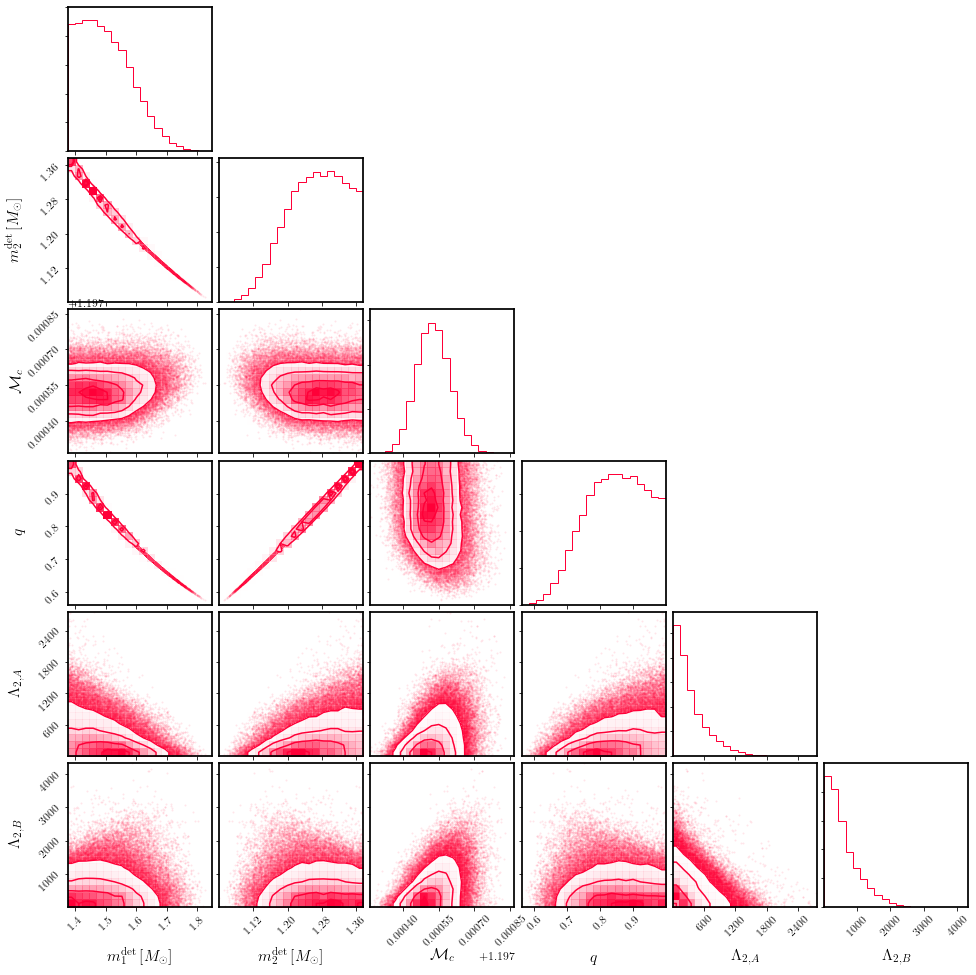

In [19]:
fig = None

# Get parameter names
urParams = [];
for i in range(0,len(URPos['Universal_Relations_Combined'].dtype.names)):
    urParams = np.append(urParams,getParam(URPos['Universal_Relations_Combined'].dtype.names[i]))

for i, pos in enumerate(URPos.values()):
    fig = corner(pos.view(float).reshape(-1, len(pos.dtype)),
                 labels=urParams,
                 label_kwargs=dict(fontsize=16),
                 color=cp[1], fig=fig)

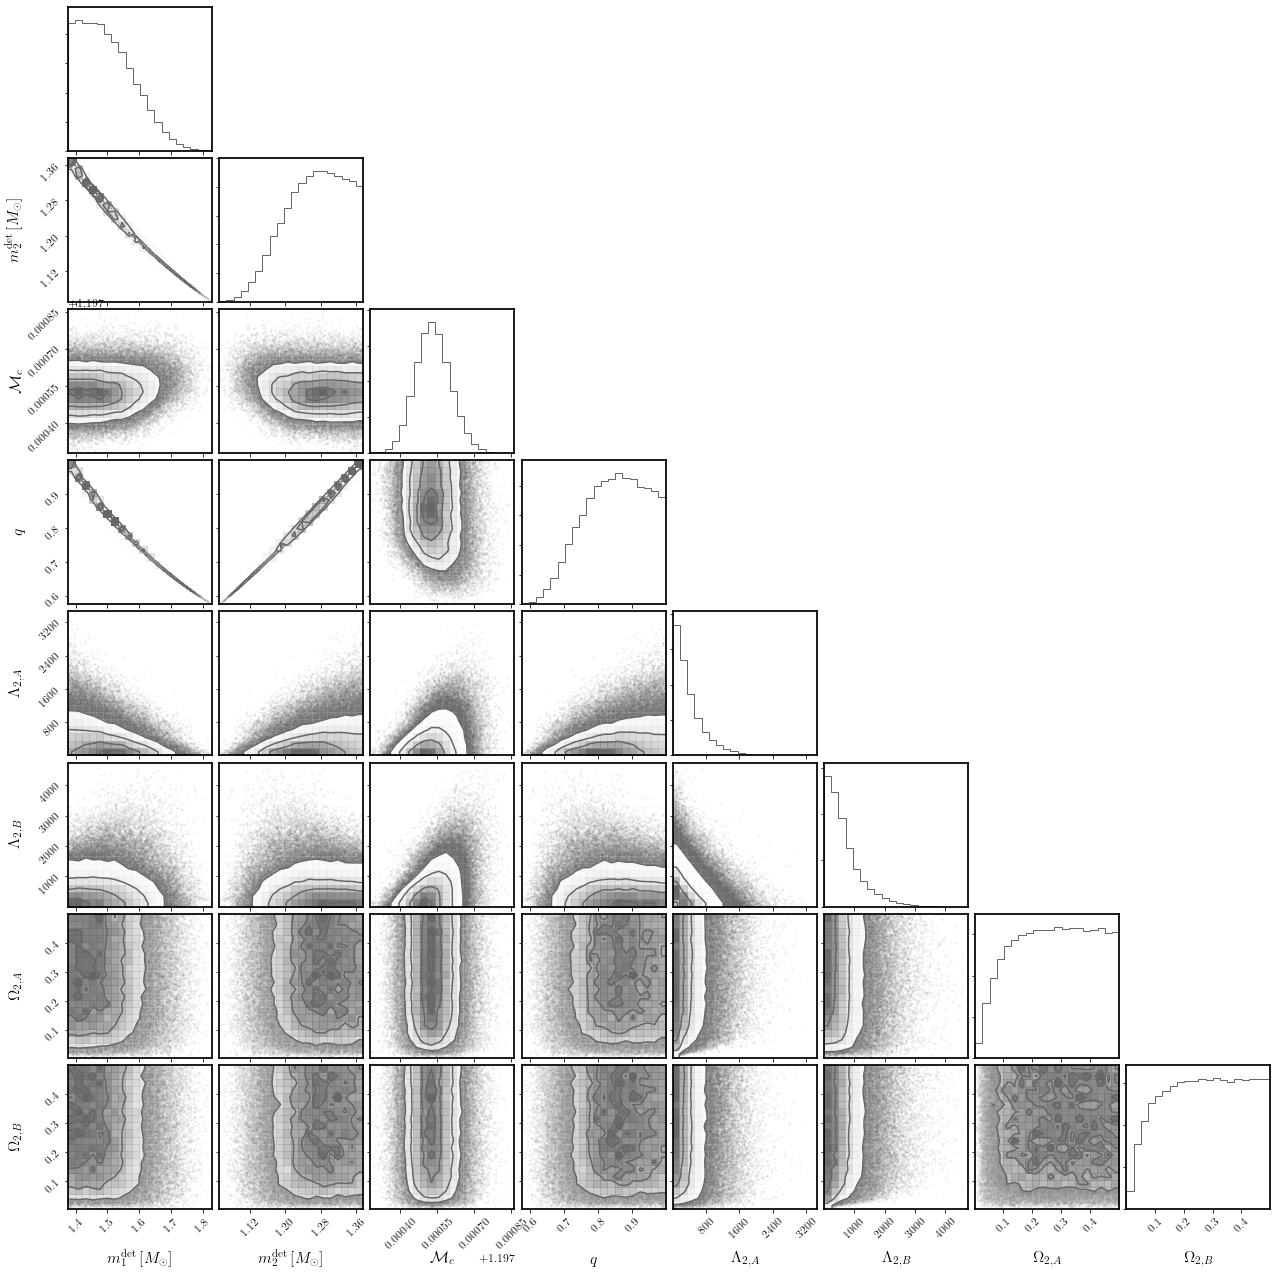

In [20]:
fig = None

# Get parameter names
quadParams = [];
for i in range(0,len(QuadPos['Quadrupolar_Combined'].dtype.names)):
    quadParams = np.append(quadParams,getParam(QuadPos['Quadrupolar_Combined'].dtype.names[i]))

for i, pos in enumerate(QuadPos.values()):
    fig = corner(pos.view(float).reshape(-1, len(pos.dtype)),
                 labels=quadParams,
                 label_kwargs=dict(fontsize=16),
                 color=cp[2], fig=fig)

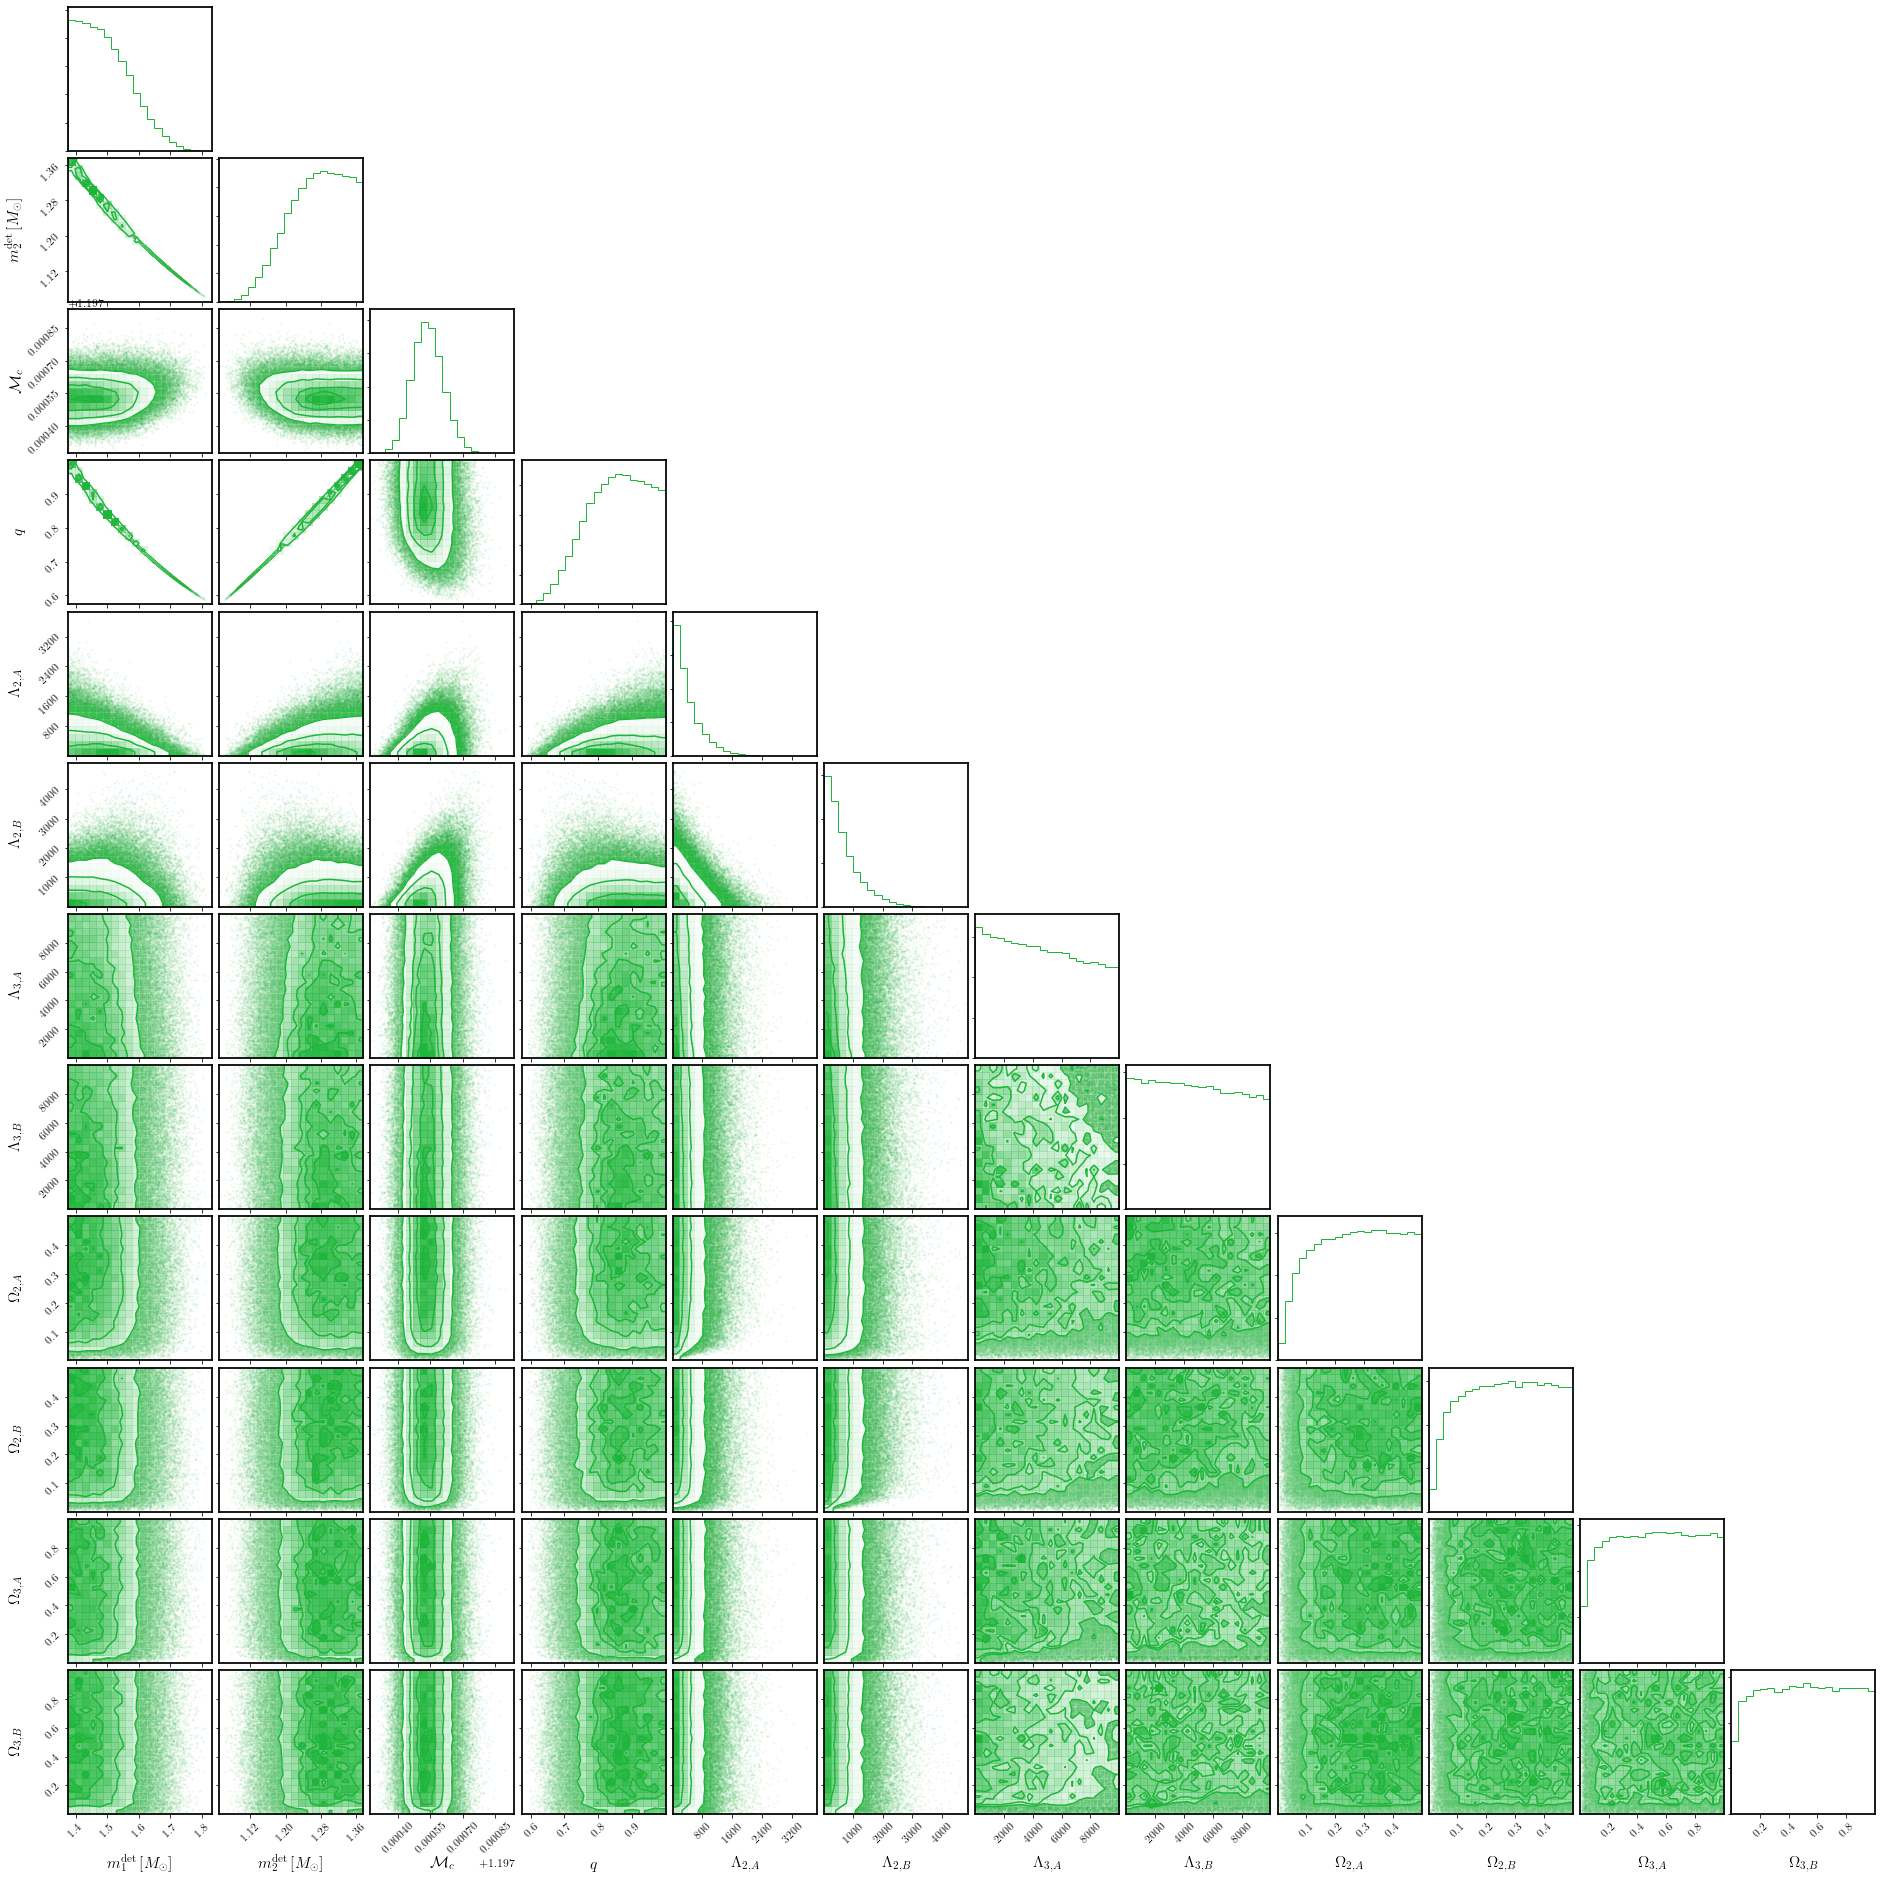

In [21]:
fig = None

# Get parameter names
octParams = [];
for i in range(0,len(OctPos['Octupolar_Combined'].dtype.names)):
    octParams = np.append(octParams,getParam(OctPos['Octupolar_Combined'].dtype.names[i]))

for i, pos in enumerate(OctPos.values()):
    fig = corner(pos.view(float).reshape(-1, len(pos.dtype)),
                 labels=octParams,
                 label_kwargs=dict(fontsize=16),
                 color=cp[3], fig=fig)

# Plot Effective Tidal Deformability: $\tilde{\Lambda}$

In [22]:
m1          = AdiabaticPos['Adiabatic_Combined']['m1_detector_frame_Msun'];
m2          = AdiabaticPos['Adiabatic_Combined']['m2_detector_frame_Msun'];
LambdaQuad1 = AdiabaticPos['Adiabatic_Combined']['lambda_quad_1'];
LambdaQuad2 = AdiabaticPos['Adiabatic_Combined']['lambda_quad_2'];
lambda_tilde_adiabatic = lambda_1_lambda_2_to_lambda_tilde(LambdaQuad1,LambdaQuad2,m1,m2);

In [23]:
m1          = URPos['Universal_Relations_Combined']['m1_detector_frame_Msun'];
m2          = URPos['Universal_Relations_Combined']['m2_detector_frame_Msun'];
LambdaQuad1 = URPos['Universal_Relations_Combined']['lambda_quad_1'];
LambdaQuad2 = URPos['Universal_Relations_Combined']['lambda_quad_2'];
lambda_tilde_ur = lambda_1_lambda_2_to_lambda_tilde(LambdaQuad1,LambdaQuad2,m1,m2);

In [24]:
m1          = QuadPos['Quadrupolar_Combined']['m1_detector_frame_Msun'];
m2          = QuadPos['Quadrupolar_Combined']['m2_detector_frame_Msun'];
LambdaQuad1 = QuadPos['Quadrupolar_Combined']['lambda_quad_1'];
LambdaQuad2 = QuadPos['Quadrupolar_Combined']['lambda_quad_2'];
lambda_tilde_quad = lambda_1_lambda_2_to_lambda_tilde(LambdaQuad1,LambdaQuad2,m1,m2);

In [25]:
m1          = OctPos['Octupolar_Combined']['m1_detector_frame_Msun'];
m2          = OctPos['Octupolar_Combined']['m2_detector_frame_Msun'];
LambdaQuad1 = OctPos['Octupolar_Combined']['lambda_quad_1'];
LambdaQuad2 = OctPos['Octupolar_Combined']['lambda_quad_2'];
lambda_tilde_oct = lambda_1_lambda_2_to_lambda_tilde(LambdaQuad1,LambdaQuad2,m1,m2);

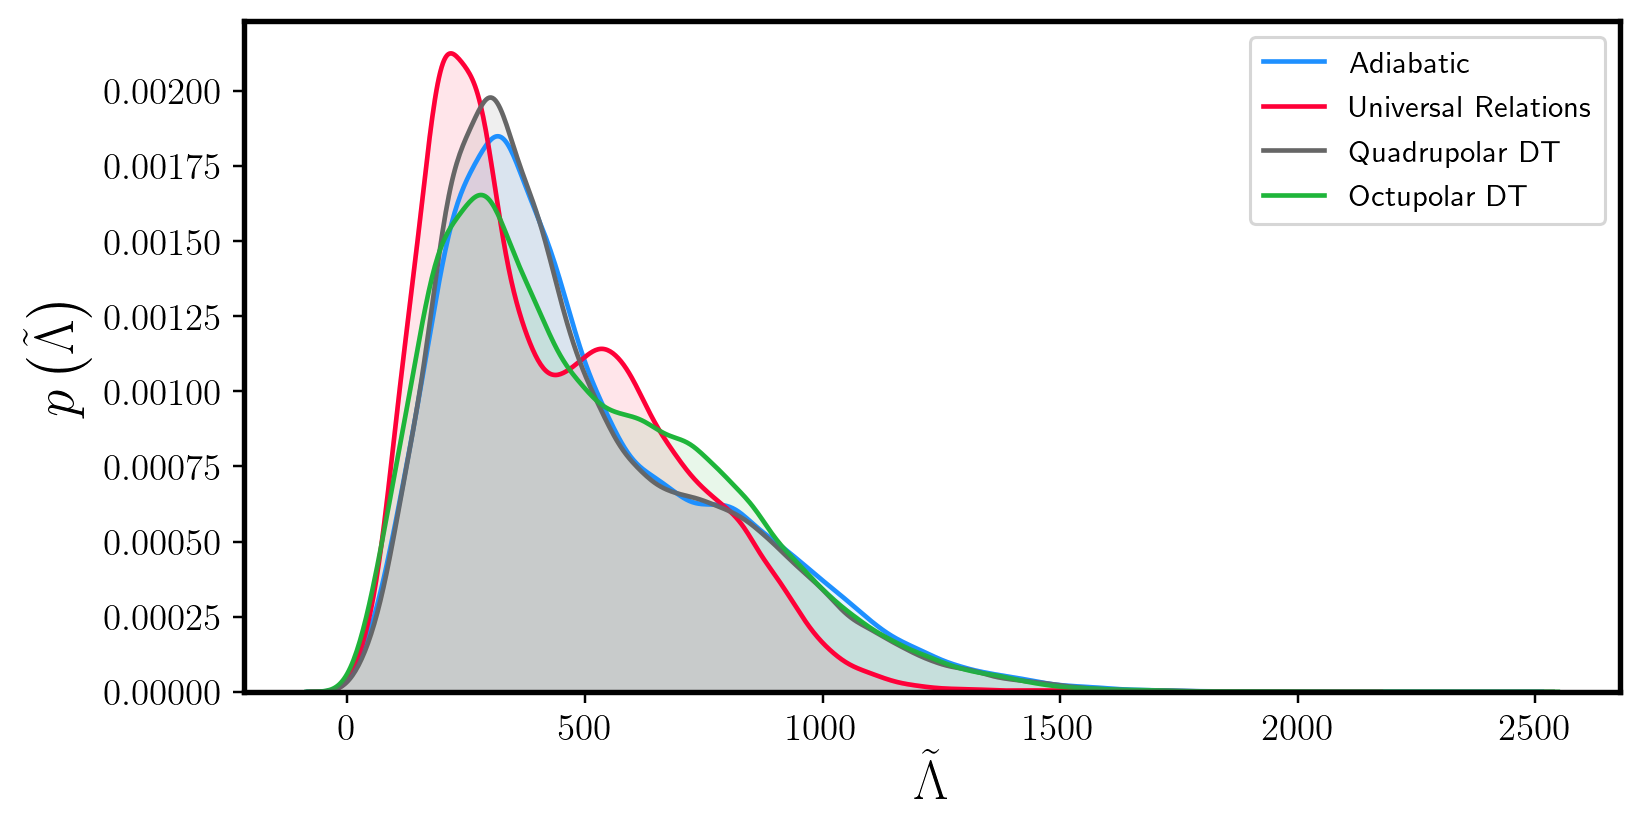

In [67]:
gs = 800;

plt.figure(figsize=(8,4),dpi=222)

# Plot without shade to keep hard KDE outline
sns.kdeplot(lambda_tilde_adiabatic,color=adiabaticCol,label='Adiabatic',shade=False,gridsize=gs);
sns.kdeplot(lambda_tilde_ur,color=urCol,label='Universal Relations',shade=False,gridsize=gs);
sns.kdeplot(lambda_tilde_quad,color=quadCol,label='Quadrupolar DT',shade=False,gridsize=gs);
sns.kdeplot(lambda_tilde_oct,color=octCol,label='Octupolar DT',shade=False,gridsize=gs);

# Plot with shade + opacity
sns.kdeplot(lambda_tilde_adiabatic,color=adiabaticCol,shade=True,gridsize=gs,alpha=0.1);
sns.kdeplot(lambda_tilde_ur,color=urCol,shade=True,gridsize=gs,alpha=0.1);
sns.kdeplot(lambda_tilde_quad,color=quadCol,shade=True,gridsize=gs,alpha=0.1);
sns.kdeplot(lambda_tilde_oct,color=octCol,shade=True,gridsize=gs,alpha=0.1);

plt.xlabel(escapeLatex(getParam('lambda_tilde')),fontsize=18);
plt.ylabel(r'$p \left( \tilde{\Lambda} \right)$',fontsize=18);

# Plot f-Mode Frequency

In [33]:
m1          = QuadPos['Quadrupolar_Combined']['m1_detector_frame_Msun'];
m2          = QuadPos['Quadrupolar_Combined']['m2_detector_frame_Msun'];
omegaQuad1  = QuadPos['Quadrupolar_Combined']['omega_quad_1'];
omegaQuad2  = QuadPos['Quadrupolar_Combined']['omega_quad_2'];

f2A_quad    = f_mode_frequency_in_Hz(m1,omegaQuad1);
f2B_quad    = f_mode_frequency_in_Hz(m1,omegaQuad1);

In [35]:
m1          = OctPos['Octupolar_Combined']['m1_detector_frame_Msun'];
m2          = OctPos['Octupolar_Combined']['m2_detector_frame_Msun'];
omegaQuad1  = OctPos['Octupolar_Combined']['omega_quad_1'];
omegaQuad2  = OctPos['Octupolar_Combined']['omega_quad_2'];

f2A_oct     = f_mode_frequency_in_Hz(m1,omegaQuad1);
f2B_oct     = f_mode_frequency_in_Hz(m1,omegaQuad1);

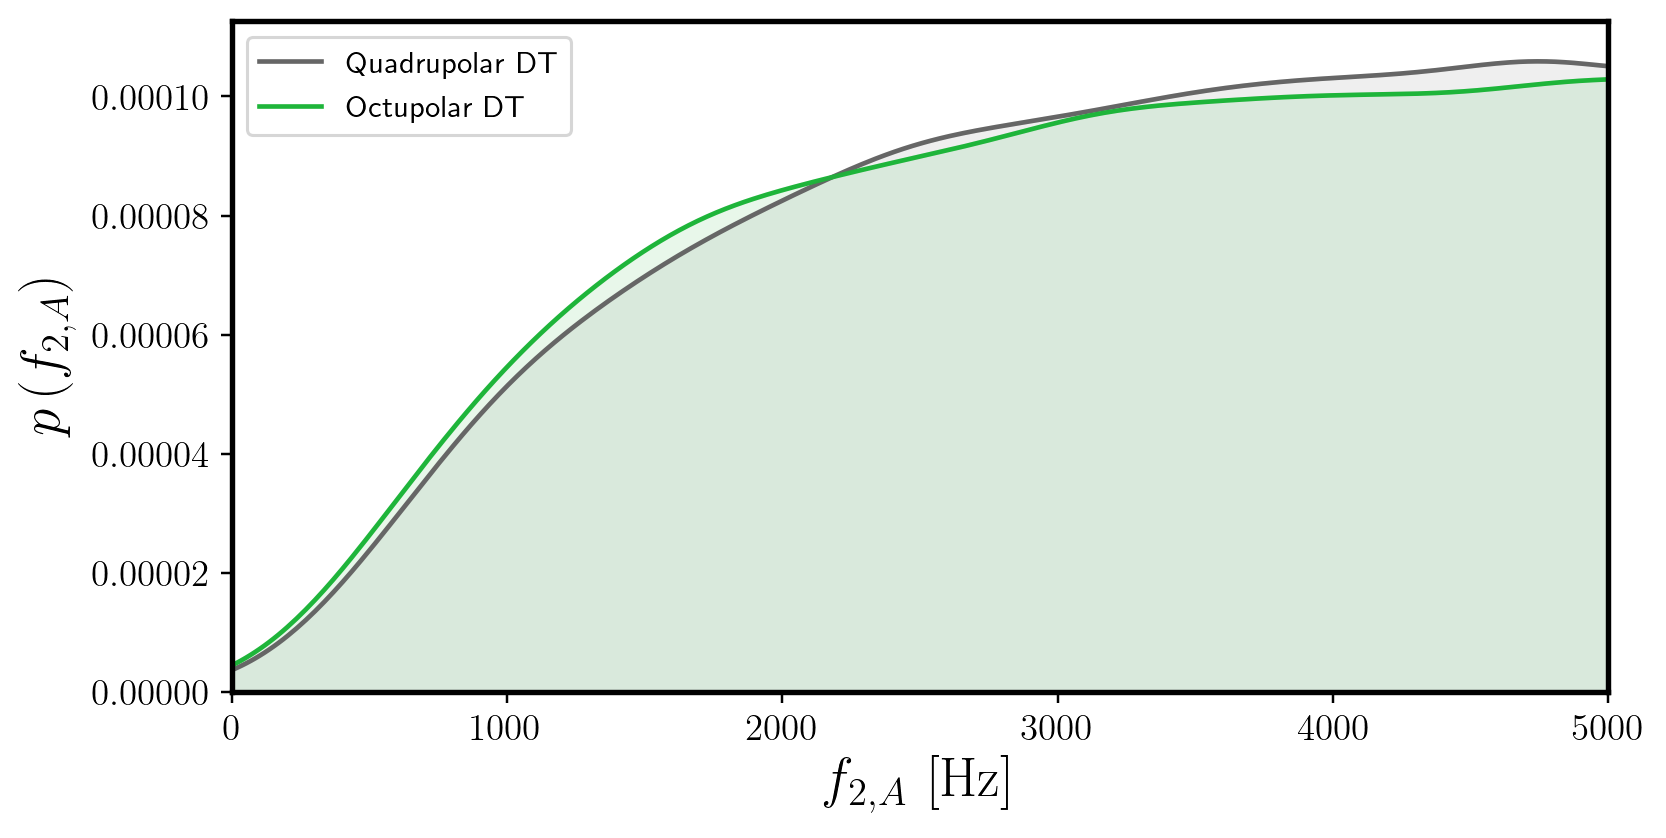

In [66]:
gs = 800;

plt.figure(figsize=(8,4),dpi=222)

# Plot without shade to keep hard KDE outline
sns.kdeplot(f2A_quad,color=quadCol,shade=False,label='Quadrupolar DT',gridsize=gs);
sns.kdeplot(f2A_oct,color=octCol,shade=False,label='Octupolar DT',gridsize=gs);

# Shade with opacity
sns.kdeplot(f2A_quad,color=quadCol,shade=True,gridsize=gs,alpha=0.1);
sns.kdeplot(f2A_oct,color=octCol,shade=True,gridsize=gs,alpha=0.1);
plt.xlim(0,5000);

plt.xlabel(r'$f_{2,A} \, \left[ \rm{Hz} \right]$',fontsize=18);
plt.ylabel(r'$p \left( f_{2,A} \right)$',fontsize=18);